In [71]:
import cv2
import numpy as np
import os
import glob
import pandas as pd
import csv
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [12]:
imagePath=r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3\data\FIDS30"
os.chdir(imagePath)
fileNames = glob.glob("*/*.jpg")
targetLabels=[]
for fileName in fileNames:
    pathSepIndex = fileName.index("\\")
    targetLabels.append(fileName[:pathSepIndex])
le = LabelEncoder()
le.fit(targetLabels)
target = le.transform(targetLabels)
X_train, X_test, y_train, y_test = train_test_split(fileNames, target, random_state=42)

In [13]:
#sift = cv2.ORB_create()
sift = cv2.xfeatures2d.SIFT_create()
dico = []
for fileName in X_train:
    img = cv2.imread(os.path.join(imagePath, fileName))
    kp, des = sift.detectAndCompute(img, None)
    for d in des:
        dico.append(d)

In [14]:
k = 700
batch_size = np.size(os.listdir(imagePath)) * 3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)

Init 1/3 with method: k-means++
Inertia for init 1/3: 4888016.144444
Init 2/3 with method: k-means++
Inertia for init 2/3: 5369286.798611
Init 3/3 with method: k-means++
Inertia for init 3/3: 5402494.638889
Minibatch iteration 1/2043700: mean batch inertia: 99478.776655, ewa inertia: 99478.776655 
Minibatch iteration 2/2043700: mean batch inertia: 96171.872239, ewa inertia: 99478.453033 
Minibatch iteration 3/2043700: mean batch inertia: 92373.410756, ewa inertia: 99477.757714 
Minibatch iteration 4/2043700: mean batch inertia: 91080.423861, ewa inertia: 99476.935929 
Minibatch iteration 5/2043700: mean batch inertia: 92756.600049, ewa inertia: 99476.278259 
Minibatch iteration 6/2043700: mean batch inertia: 92933.616677, ewa inertia: 99475.637976 
Minibatch iteration 7/2043700: mean batch inertia: 90379.692406, ewa inertia: 99474.747823 
Minibatch iteration 8/2043700: mean batch inertia: 88371.886476, ewa inertia: 99473.661267 
Minibatch iteration 9/2043700: mean batch inertia: 85936.

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=288 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=288 should be larger than k=700. Setting it to 3*k
  init_size=init_size)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\cluster\k_means_.py:1558: RuntimeWarning: init_size=288 should be larger than k=700. Setting it to 3*k
  init_size=init_size)


In [15]:
kmeans.verbose = False
histo_list = []
for fileName in X_train:
    img = cv2.imread(os.path.join(imagePath, fileName))
    kp, des = sift.detectAndCompute(img, None)
    histo = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        histo[idx] += 1/nkp # Because we need normalized histograms, I prefer to add 1/nkp directly
    histo_list.append(histo)    

In [56]:
X = np.array(histo_list)

#mlp = MLPClassifier(verbose=True, max_iter=600)
#mlp.fit(X, y_train)
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
len(X_train)

728

In [39]:
predictions = []
xes_test = []
for fileName in X_test:
    img = cv2.imread(os.path.join(imagePath, fileName))
    kp, des = sift.detectAndCompute(img, None)
    x = np.zeros(k)
    nkp = np.size(kp)
    for d in des:
        idx = kmeans.predict([d])
        x[idx] += 1/nkp
    #res = clf.predict_proba([x])
    predictions.append(clf.predict([x]))
    xes_test.append(x)
    

In [57]:
print ('RF accuracy: TRAINING', clf.score(X,y_train))
print ('RF accuracy: TESTING', clf.score(xes_test,y_test))
#RF accuracy: TRAINING 0.9986263736263736
#RF accuracy: TESTING 0.21810699588477367

RF accuracy: TRAINING 1.0
RF accuracy: TESTING 0.3497942386831276


In [61]:
XX = X.copy()
XX = np.concatenate((XX, np.array(xes_test)))
YY = np.concatenate((y_train, y_test))

In [62]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
rfclf_param_grid = {
  "n_estimators": [100, 300],
  "max_depth": [5, 7, None],
  "max_features": [5, "auto"],
  }
rfclf = RandomForestClassifier()
rfclf_grid_search = GridSearchCV(rfclf, param_grid=rfclf_param_grid, cv=10, n_jobs=1)
rfclf_grid_search.fit(XX, YY)
report(rfclf_grid_search.cv_results_) 

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.405 (std: 0.043)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 300}

Model with rank: 2
Mean validation score: 0.393 (std: 0.045)
Parameters: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.370 (std: 0.037)
Parameters: {'max_depth': None, 'max_features': 5, 'n_estimators': 300}



In [65]:
mlpclf_param_grid = {"hidden_layer_sizes": [(100,), (150,), (100,30), (50,50)], #, (30, 30, 20), smaller ones e.g. 10; 15; 15,15 worse
              "activation": [ "relu"], #tanh worse
              "solver": ["adam"], #lbfgs worse
              "alpha": [0.00003, 0.0001, 0.001], #0.0001, 0.005, 
              "max_iter": [500]} # 100, 200 worse, does not converge
mlpclf = MLPClassifier()
mlpclf_grid_search = GridSearchCV(mlpclf, param_grid=mlpclf_param_grid, cv=10, n_jobs=1)
mlpclf_grid_search.fit(XX, YY)
report(mlpclf_grid_search.cv_results_) 

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_net

Model with rank: 1
Mean validation score: 0.526 (std: 0.044)
Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150,), 'max_iter': 500, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.524 (std: 0.054)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150,), 'max_iter': 500, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.516 (std: 0.040)
Parameters: {'activation': 'relu', 'alpha': 3e-05, 'hidden_layer_sizes': (150,), 'max_iter': 500, 'solver': 'adam'}



In [69]:
classifiers = [("Kneighbors", KNeighborsClassifier()),
               ('GaussianNB', GaussianNB()), 
               ('RandomForest', RandomForestClassifier()),
               ('RandomForest_OPT', RandomForestClassifier(n_estimators=300)),
               ('SVC', SVC()),
               ('MLP', MLPClassifier()),
               ('MLP_OPT', MLPClassifier(alpha=0.001, hidden_layer_sizes=(150,), max_iter=500))
              ]
arr = []
for classifier_tuple in classifiers:
    print(classifier_tuple[0]) 
    scores = cross_val_score(classifier_tuple[1], XX, YY, cv=10)
    #print(cross_val_score(classifier, train, target, cv=3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    arr.append(scores.mean())

Kneighbors
Accuracy: 0.31 (+/- 0.06)
GaussianNB
Accuracy: 0.40 (+/- 0.11)
RandomForest
Accuracy: 0.22 (+/- 0.10)
RandomForest_OPT
Accuracy: 0.43 (+/- 0.10)
SVC
Accuracy: 0.08 (+/- 0.02)
MLP
Accuracy: 0.42 (+/- 0.06)
MLP_OPT
Accuracy: 0.52 (+/- 0.09)


c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators wil

In [78]:
classifier_names = [clf_tuple[0] for clf_tuple in classifiers]
df = pd.DataFrame(data=arr,columns=['accuracy'])
df['classifier'] = classifier_names

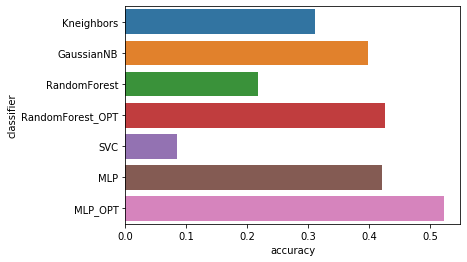

In [80]:
sns.barplot(x="accuracy", y="classifier", data=df)